# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В качестве исходных данных выступают исторические данные: технические характеристики, комплектации и цены автомобилей. 

<b>Задача проекта:</b> построить модель для определения стоимости автомобиля. 

<b>Заказчику важны:</b>
- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки:</b>
- <i>DateCrawled</i> — дата скачивания анкеты из базы
- <i>VehicleType</i> — тип автомобильного кузова
- <i>RegistrationYear</i> — год регистрации автомобиля
- <i>Gearbox</i> — тип коробки передач
- <i>Power</i> — мощность (л. с.)
- <i>Model</i> — модель автомобиля
- <i>Kilometer</i> — пробег (км)
- <i>RegistrationMonth</i> — месяц регистрации автомобиля
- <i>FuelType</i> — тип топлива
- <i>Brand</i> — марка автомобиля
- <i>Repaired</i> — была машина в ремонте или нет
- <i>DateCreated</i> — дата создания анкеты
- <i>NumberOfPictures</i> — количество фотографий автомобиля
- <i>PostalCode</i> — почтовый индекс владельца анкеты (пользователя)
- <i>LastSeen</i> — дата последней активности пользователя

<b>Целевой признак:</b>
- <i>Price</i> — цена (евро)

<b>План проекта:</b>
1. загрузить и изучить данные;
2. предобработка признаков;
3. подготовка выборок для обучения;
4. обучить разные модели с варьированием гиперпараметров;
5. проанализировать время обучения, время предсказания и качество моделей;
6. выбрать лучшую модель и проверьте её качество на тестовой выборке.


## Подготовка данных

In [5]:
#загрузим необходимые библиотеки

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from pandas_profiling import ProfileReport

In [6]:
#Загрузим датасет
pth1 = '/datasets/autos.csv'
pth2 = 'autos.csv'

if os.path.exists(pth1):
    df_raw = pd.read_csv(pth1)
    print('platform')
else:
    df_raw = pd.read_csv(pth2)
    print('remote')

remote


In [ ]:
'''подробный отчет об исходных данных создан при помощи Profiling Report

profile = ProfileReport(df_raw, title="Pandas Profiling Report")
profile'''

Из отчета выше можно выделить несколько важных свойств датасета: 
- всего пропущено 3.2% данных;
- встречаются дубликаты;
- столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen - можно удалить, поскольку эти данные не относятся к свойствам автомобиля;
- в столбце VehicleType - пропущено 10.6%, в Gearbox - пропущено 5.6%, в Model - пропущено 5.6%, в FuelType - пропущено 9.3%, в Repaired - пропущено 20%;
- по данным отчета признаки RegistrationYear и VehicleType, а также Brand и Gearbox имеют высокую и среднюю корреляцию.

Поскольку модели, которые далее будут обучены, не чувствительны к мультиколлинераности (компенсируют корреляцию признаков с помощью весов) - столбцы RegistrationYear, VehicleType, Brand, Gearbox не будут удалены.

In [8]:
#удалим дублирующиеся строки
df_raw = df_raw.drop_duplicates()

In [9]:
#столбцы в списке ниже можно удалить, поскольку они не несут важной информации для данной задачи
#кроме того, удалим столбец RegistrationMounth, поскольку признак RegistrationYear важнее для определения цены 
#и оставлять два похожих по функции признака не имеет смысла.
uninformative = ['DateCrawled', 'DateCreated', 'LastSeen', 
                 'NumberOfPictures', 'PostalCode', 'RegistrationMonth']

df = df_raw.drop(uninformative, axis=1)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Значения в категориальных столбцах сложно заполнить осмыслено без дополнительной информации. Поскольку природа пропусков неизвестна, заполним пропуски значением 'unknown'.

In [10]:
#заменим пропущенные значения в категориальных столбцах на unknown
unknown = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

df[unknown] = df[unknown].fillna('unknown')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


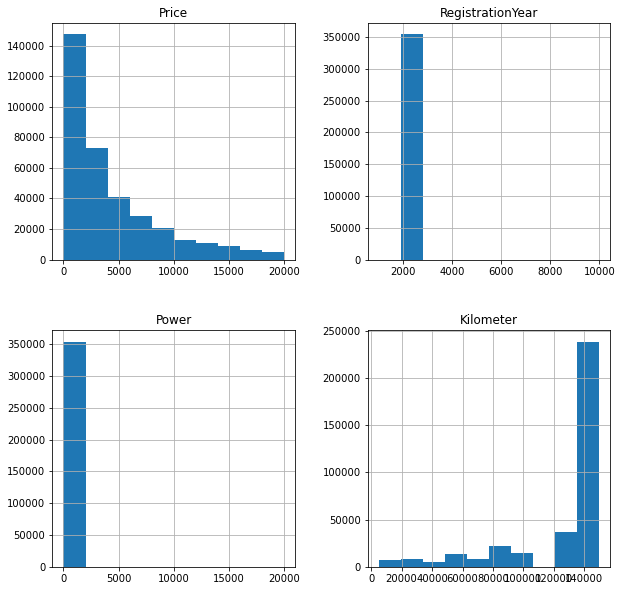

In [12]:
#посмотрим подробнее на частоты значений в численных колонках
df.hist(figsize=(10, 10))
None

В столбцах RegistrationYear и Power встречаются аномальные значения. Кроме того, в столбце Price большое количество нулевых значений.

In [13]:
#посчитаем количество нулевых значений в столбце Price
df[df['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
111,0,unknown,2017,manual,0,golf,5000,petrol,volkswagen,unknown
115,0,small,1999,unknown,0,unknown,5000,petrol,volkswagen,unknown
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,unknown,2000,manual,65,corsa,150000,unknown,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [14]:
#поскольку признак Price - целевой, с ним сложно что-либо сделать в данной задаче. Поэтому удалим строки с нулевой ценой.
df = df[df['Price'] != 0]

count    343593.000000
mean     128337.815380
std       37520.773792
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

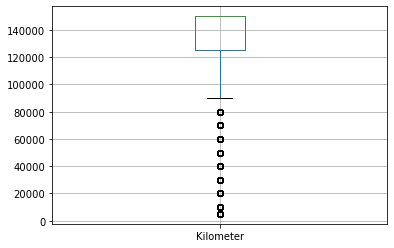

In [15]:
# Прежде чем обработать аномалии, посмотрим подробнее на распределение значений в столбце Kilometer
display(df['Kilometer'].describe())

df.boxplot(column=['Kilometer'])
plt.show()

Данные в столбце Kilometer распределены со смещением вправо. Кроме того, здесь достаточно много выбросов, удалив которые, будет потеряно большое количество данных. Оставим этот столбец как есть. 

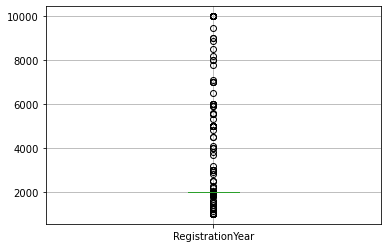

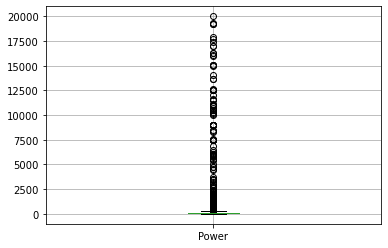

In [16]:
#далее посмотрим подробнее на столбцы с аномалиями

df.boxplot(column=['RegistrationYear'])
plt.show()

df.boxplot(column=['Power'])
plt.show()

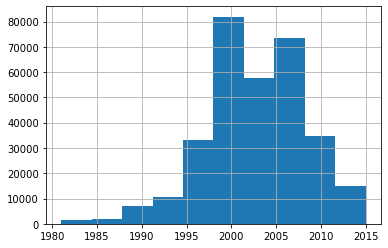

In [17]:
#отсечем верхнюю и нижнию границы года релиза авто
#нижняя граница выбрана из соображений исключения из данных слишком старых авто (их немного).

df = df[(df['RegistrationYear'] > 1980) & (df['RegistrationYear'] < 2016)]
df['RegistrationYear'].hist();

In [18]:
#далее поработаем со столбцом Power
df.groupby('Power')['RegistrationYear'].agg(['count','mean'])

,count,mean
Power,,
0,29171,2000.502897
1,22,2002.000000
2,8,2003.375000
3,8,1998.875000
4,30,2001.200000
...,...,...
17932,1,2001.000000
19208,1,2001.000000
19211,1,2006.000000


In [19]:
#удалим нулевые значения, а также строки с значеним мощности более 500. 
# Посольку мощность более 500 л.с. встречается у небольшого количества экземпляров
df = df[(df['Power'] !=0) & (df['Power'] < 500)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287619 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             287619 non-null  int64 
 1   VehicleType       287619 non-null  object
 2   RegistrationYear  287619 non-null  int64 
 3   Gearbox           287619 non-null  object
 4   Power             287619 non-null  int64 
 5   Model             287619 non-null  object
 6   Kilometer         287619 non-null  int64 
 7   FuelType          287619 non-null  object
 8   Brand             287619 non-null  object
 9   Repaired          287619 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.1+ MB


Данные удалось сохранить после обработки без значительных потерь:
- неинформативные столбцы удалены;
- удалены дубликаты;
- пропуски в категориальных столбцах заменены на unknown;
- аномалии обработаны.

## Обучение моделей

Далее обучим классические и бустинговые модели машинного обучения. Создадим два набора выобор - одна с закодированными категориальными данными, а вторая с категориальными столбцами без изменений, поскольку некоторые модели могут принимать на вход категориальные признаки.

In [20]:
#создадим общую выборку с признаками и целевыми значениями
X = df.drop(['Price'], axis=1)
y = df['Price']

#определим названия категориальных столбцов для обучения моделей бустинга
cat_col = X.select_dtypes('object').columns.tolist()

#выделим набор данных для обучающей, валидационной и тестовой выборки в два этапа.
#отделим сначала обучающую выборку, равной 60% от исходных данных
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, shuffle=True, test_size=0.4, stratify=None, random_state=12345)

#далее разделим оставшиеся 40% данных на валидационную и тестовую выборки пополам
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, shuffle=True, test_size=0.5, stratify=None, random_state=12345)


#убедимся, что размер выборок корректен
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(172571, 9)
(172571,)

(57524, 9)
(57524,)


In [21]:
#для того, чтобы обучить классические модели, необходимо закодировать категориальные столбцы
#скопируем выборки
X_classic = X.copy()
y_classic = y.copy()

#в признаках ниже слишком много уникальных значений, поэтому удалим этот столбец 
X_classic = X_classic.drop(['Model'], axis=1)

#определим столбцы для кодирования
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand']

X_cat = X_classic[categorical]

#определим кодировщик
ohenc = OneHotEncoder(sparse=False)
x_cat_df = pd.DataFrame(ohenc.fit_transform(X_cat))

# вернем индексы, которые удалил кодировщик
x_cat_df.index = X_classic.index

# вернем имена столбцов
x_cat_df.columns = ohenc.get_feature_names_out(input_features=X_cat.columns)

# объединим данные в новый датафрейм
X_classic = pd.concat([X_classic.drop(categorical, axis=1), x_cat_df], axis=1)

#в итоге получим датасет признаков с полностью числовыми значениями
X_classic

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
1,2011,190,125000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,163,125000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2001,75,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2008,69,90000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1995,102,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2005,3,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354362,2004,225,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354366,2000,101,125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354367,1996,102,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
#выделим набор данных для обучающей, валидационной и тестовой выборки в два этапа.
#отделим сначала обучающую выборку, равной 60% от исходных данных
X_train_classic, X_temp_classic, y_train_classic, y_temp_classic = train_test_split(
    X_classic, y_classic, shuffle=True, test_size=0.4, stratify=None, random_state=12345)

#далее разделим оставшиеся 40% данных на валидационную и тестовую выборки пополам
X_valid_classic, X_test_classic, y_valid_classic, y_test_classic = train_test_split(
    X_temp_classic, y_temp_classic, shuffle=True, test_size=0.5, stratify=None, random_state=12345)


#убедимся, что размер выборок корректен
print(X_train_classic.shape)
print(y_train_classic.shape)
print()
print(X_valid_classic.shape)
print(y_valid_classic.shape)
print()
print(X_test_classic.shape)
print(y_test_classic.shape)

(172571, 66)
(172571,)

(57524, 66)
(57524,)

(57524, 66)
(57524,)


### Классические модели обучения

In [23]:
#выполним масштабирование признаков для модели линейной регрессии
X_train_scaled = X_train_classic.copy()
X_valid_scaled = X_valid_classic.copy()

#определим численные столбцы для масштабирования
numeric = ['RegistrationYear', 'Power', 'Kilometer']

#определим более устойчивый к выбросам инструмент для масштабирования
scaler = RobustScaler()
X_train_scaled[numeric] = scaler.fit_transform(X_train_scaled[numeric])
X_valid_scaled[numeric] = scaler.transform(X_valid_scaled[numeric])

display(X_train_scaled)
display(X_valid_scaled)

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
95423,0.375,-0.125000,-4.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87516,0.375,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61506,-0.125,-0.847222,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107446,-0.375,-0.541667,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344791,0.250,-0.680556,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195758,0.125,0.027778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
59104,1.250,-0.125000,-5.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106430,0.750,-0.625000,-3.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
95219,-0.500,-0.750000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
169053,-0.500,0.013889,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
301303,-0.625,3.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246796,-1.625,0.055556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205228,0.250,-0.125000,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112226,-0.125,2.194444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325001,-0.750,-0.180556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209584,1.125,-0.638889,-4.4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252862,0.250,0.083333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328388,-0.125,-0.750000,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Исследуем модель по методу линейной регрессии и гиперпараметрами по умолчанию
start = time.time()

model = LinearRegression() #обучим модель

model.fit(X_train_scaled, y_train_classic) # обучим модель на тренировочной выборке
predictions = model.predict(X_valid_scaled) # получим предсказания модели
result_linear = mean_squared_error(y_valid_classic, predictions) ** 0.5  # посчитаем качество модели для предсказания

end = time.time()

time_linear = round(end-start, 2)

print("RMSE линейная регрессия:", round(result_linear, 4))
print("Время обучения и предсказания:", time_linear)

RMSE линейная регрессия: 2498.1063
Время обучения и предсказания: 0.36


In [25]:
# обучим модель Случайный лес с заданными оптимальными гиперпараметрами
#гиперапарметры были найдены ранее при помощи GridSearchCV. Этот код удален, поскольку подбор занимает много времени.
start = time.time()

model_forest = RandomForestRegressor(max_depth=7, n_estimators=91, random_state=42)

model_forest.fit(X_train_classic, y_train_classic) # обучиим модель на тренировочной выборке
predicted_valid_forest = model_forest.predict(X_valid_classic)#получим предсказание
result_forest = mean_squared_error(y_valid_classic, predicted_valid_forest) ** 0.5

end = time.time()
time_forest = round(end-start, 2)

print('RMSE случайный лес:',"%.4f" % result_forest)
print("Время обучения и предсказания:", time_forest)

RMSE случайный лес: 2065.1334
Время обучения и предсказания: 37.11


Классические модели обучаются достаточно быстро. Метрики для обеих моделей получились меньше достимого (2500).

### Модель LightGBM

In [26]:
#зададим вычисление метрики качества rmse с помощью функции
def rmse(predict, actual):
    score = mean_squared_error(actual, predict, squared=False)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [27]:
#обучим модель LightGBM

#для того чтобы модель могла воспринимать категориальные значения, 
# необходимо переформатировать столбцы из object в category
for feature in cat_col:
    X_train[feature] = pd.Series(X_train[feature], dtype='category')
    X_valid[feature] = pd.Series(X_valid[feature], dtype='category')
    X_test[feature] = pd.Series(X_test[feature], dtype='category')
    
    
#выберем диапазон параметров для варьирования один раз для всех моделей, чтобы сравнение было корректным
param_grid = {'learning_rate': [0.1, 0.3]}

params_lgb = {
    'n_estimators': 1000,
    'categorical_features': cat_col,
    'objective': 'rmse',
    'random_state': 42}

clf = lgb.LGBMRegressor(**params_lgb)

#определим и обучим модель
model_lgb = GridSearchCV(clf, param_grid = param_grid, scoring=rmse_score, cv=3)
model_lgb.fit(X_train, y_train)

#получим лучший результат
result_lgb = abs(model_lgb.best_score_)

print('RMSE LightGBM:',"%.4f" %result_lgb)

RMSE LightGBM: 1488.0964


In [28]:
#выведем среднее время обучения и предсказания для одной выборки кросс-валидации 
train_lgb = model_lgb.cv_results_['mean_fit_time'].mean()
pred_lgb = model_lgb.cv_results_['mean_score_time'].mean()

### Модель CatBoost

In [29]:
#обучим модель CatBoost
start = time.time()

#определим параметры модели
params_cb = {'cat_features': cat_col,
              'loss_function': 'RMSE',
              'n_estimators': 300,
              'random_seed':42,
              'verbose':100}

clf = CatBoostRegressor(**params_cb)

#определим и обучим модель
model_cb = GridSearchCV(clf, param_grid = param_grid, scoring=rmse_score, cv=3)
model_cb.fit(X_train, y_train)

#получим лучший результат
result_cb = abs(model_cb.best_score_)

end = time.time()

#сохраним время в отдельной переменной
t_cb = end-start

print('RMSE CatBoost:',"%.4f" %result_cb)

0:	learn: 4284.8858554	total: 294ms	remaining: 1m 27s
100:	learn: 1669.2643726	total: 14s	remaining: 27.6s
200:	learn: 1592.0408900	total: 27.9s	remaining: 13.8s
299:	learn: 1554.6982413	total: 39.9s	remaining: 0us
0:	learn: 4276.3620703	total: 130ms	remaining: 38.9s
100:	learn: 1674.9847534	total: 12.9s	remaining: 25.4s
200:	learn: 1597.3939669	total: 27.1s	remaining: 13.3s
299:	learn: 1558.7597873	total: 40.7s	remaining: 0us
0:	learn: 4277.0624982	total: 157ms	remaining: 46.9s
100:	learn: 1670.4289653	total: 13.8s	remaining: 27.3s
200:	learn: 1594.3647369	total: 27.3s	remaining: 13.5s
299:	learn: 1557.6192880	total: 40.7s	remaining: 0us
0:	learn: 3677.2319311	total: 151ms	remaining: 45s
100:	learn: 1563.1652279	total: 11.7s	remaining: 23s
200:	learn: 1500.6668113	total: 24.1s	remaining: 11.9s
299:	learn: 1461.8343742	total: 38.1s	remaining: 0us
0:	learn: 3688.3833253	total: 161ms	remaining: 48.3s
100:	learn: 1564.0810912	total: 13.4s	remaining: 26.5s
200:	learn: 1504.0506324	total: 2

In [30]:
#выведем среднее время обучения и предсказания для одной выборки кросс-валидации 
train_cb = model_cb.cv_results_['mean_fit_time'].mean()
pred_cb = model_cb.cv_results_['mean_score_time'].mean()

### Модель XGBoost

In [31]:
#обучим модель бустинга XGBoost

#определим параметры модели
params_xgb = {'objective': 'reg:linear',
              'n_estimators': 300,
              'random_state': 42}

#определим модель
clf = xgb.XGBRegressor(**params_xgb)

#определим модель
model_xgb = GridSearchCV(clf, param_grid = param_grid, scoring=rmse_score, cv=3)

#обучим модель. здесь используются датасеты с закодированными столбцами, 
#поскольку данная модель не работает с категориальными значениями
model_xgb.fit(X_train_classic, y_train_classic)

#получим лучший результат
result_xgb = abs(model_xgb.best_score_)

print('RMSE CatBoost:',"%.4f" %result_xgb)

[17:06:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [32]:
#выведем среднее время обучения и предсказания для одной выборки кросс-валидации 
train_xgb = model_xgb.cv_results_['mean_fit_time'].mean()
pred_xgb = model_xgb.cv_results_['mean_score_time'].mean()

## Анализ моделей

Для анализа результатов работы моделей соберем все ключевые показатели в одну таблицу.

In [33]:
pd.options.display.float_format = '{:.2f}'.format #зададим настройку ограничивающую точность значений

# преобразуем полученные данные в датафрейм
all_results = pd.DataFrame()       

all_results['RMSE'] = [result_lgb, result_cb, result_xgb]
all_results['train time'] = [train_lgb, train_cb, train_xgb]
all_results['prediction time'] = [pred_lgb, pred_cb, pred_xgb]
all_results['Model'] = ['LightGBM', 'CatBoost', 'XGBoost']

# выведем итоговую таблицу
all_results

,RMSE,train time,prediction time,Model
0,1488.10,3.01,0.89,LightGBM
1,1559.34,40.10,0.09,CatBoost
2,1568.26,31.79,0.17,XGBoost


Классические модели показали гораздо худшее значение целевой метрики. Градиентные модели обучаются гораздо дольше, но и качество этих моделей гораздо выше для данной задачи. Следует отметить, что датасет для модели XGBoost не содержит столбец Model, поэтому качество могло получиться немного хуже. Самой быстрой и лучшей по качеству оказалась модель LightGBM. Скорость обучения также выше у LightGBM, но скорость предсказания самая низкая. Самая быстрая скорость предсказаний у модели CatBoost. Далее получим предсказания на тестовых данных и оценим метрику RMSE.

In [34]:
#далее получим предсказания и целевую метрику для лучшей модели на тестовой выборке
start = time.time()

model_best = lgb.LGBMRegressor(**model_lgb.best_params_, random_state=42)

#обучим модель
model_best.fit(X_train, y_train, verbose=100)

#далее получим предсказание и выведем метрику RMSE
prediction = model_best.predict(X_test)
result = mean_squared_error(y_test, prediction)** 0.5

end = time.time()

print('RMSE LightGBM:',"%.4f" %result)
print("Время обучения и предсказания:", round(end-start, 2))

RMSE LightGBM: 1562.7709
Время обучения и предсказания: 0.82


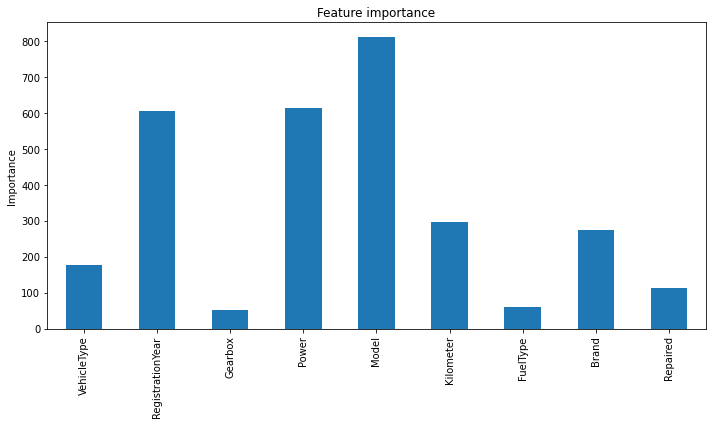

In [35]:
# посмотрим на признаки, наиболее сильно влияющие на целевую метрику
imp = pd.Series(model_best.feature_importances_,
               X_train.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

Наибольшее влияние на стоимость авто оказывают модель, год выпуска и мощность двигателя. Полученный результат не противоречит общепринятому порядку ценообразования.

## Выводы

Выполнена задача проекта - построена модель для определения стоимости автомобиля с наилучшим показателем RMSE и наименьшим временем обучения и предсказания. 

<b>Выполненные этапы и результаты:</b>
1. данные загружены и изучены;
2. выполнена предобработка признаков в ходе которой были удалены дубликаты, обработаны пропуски и устранены аномальные значения, кроме того, были удалены неинформативные признаки;
3. обучены классические и бустинговые модели. Результаты:
   - Линейная регрессия: RMSE - 2498, время обучения и предсказания - 0,56 сек;
   - Случайный лес: RMSE - 2065, время обучения и предсказания - 43 сек;
   - LightGBM: RMSE - 1488, время обучения - 3,72 сек, время предсказания - 0,86 сек;
   - CatBoost: RMSE - 1559, время обучения - 38,05 сек, время предсказания - 0,09 сек;
   - XGBoost: RMSE - 1568, время обучения - 32,18 сек, время предсказания - 0,18 сек;
4. выбрана лучшая модель - LightGBM. Результаты на тестовой выборке:
   - RMSE - 1563, 
   - время - 0.56 сек.